In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Chạy các lệnh sau để cài đặt toàn bộ môi trường cho mô hình:
Chạy các lệnh sau để cài đặt toàn bộ môi trường cho mô hình:
```bash
!pip install torch torchvision torchaudio
!pip install opencv-python matplotlib numpy
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install scikit-learn
!pip install pillow
!pip install scikit-image



### 1. Import các thư viện cần thiết

Đầu tiên, chương trình cần import các thư viện hỗ trợ xử lý dữ liệu, hình ảnh và huấn luyện mô hình học máy:
```python
import os                          # Quản lý tệp và thư mục
import numpy as np                 # Xử lý dữ liệu số, mảng và ma trận
import pandas as pd                # Xử lý dữ liệu dạng bảng
import cv2                         # Xử lý và thao tác với hình ảnh
from PIL import Image              # Thư viện hỗ trợ đọc và xử lý ảnh
import matplotlib.pyplot as plt    # Vẽ biểu đồ và hiển thị hình ảnh
import torch                       # Thư viện học sâu (deep learning)
from segment_anything import sam_model_registry, SamPredictor  # Mô hình Segment Anything
from sklearn.linear_model import LogisticRegression             # Hồi quy logistic
from sklearn.model_selection import train_test_split            # Chia dữ liệu train/test
from sklearn.metrics import accuracy_score                      # Đánh giá độ chính xác mô hình
import seaborn as sns              # Vẽ biểu đồ trực quan hóa dữ liệu


In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry, SamPredictor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns

Khởi tạo mô hình Segment Anything (SAM2) và Logistic Regression

Đoạn mã dưới đây thực hiện:
- Import các thư viện cần thiết
- Tải checkpoint của mô hình **SAM2 ViT-B**
- Thiết lập thiết bị chạy (`cuda` hoặc `cpu`)
- Khởi tạo **SamPredictor** để trích xuất đặc trưng từ ảnh.

In [ ]:
import os
import numpy as np
from PIL import Image
import torch
from segment_anything import sam_model_registry, SamPredictor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sam_checkpoint = "/content/drive/MyDrive/classfication/SAM2/sam_vit_b_01ec64.pth"
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
print("SAM2 ViT-B loaded successfully")

Using device: cuda
SAM2 ViT-B loaded successfully


Trích xuất đặc trưng ảnh bằng mô hình SAM2

Đoạn mã dưới đây thực hiện các bước:
- Duyệt toàn bộ thư mục ảnh trong `DATA_DIR` và đọc tối đa `MAX_IMAGES_PER_LABEL` ảnh cho mỗi nhãn.  
- Tiền xử lý ảnh (chuyển sang RGB, resize về kích thước `IMAGE_SIZE × IMAGE_SIZE`).  
- Sử dụng **SAM2 Predictor** để trích xuất **image embeddings** cho từng ảnh.  
- Lưu trữ kết quả vào `X_features` (đặc trưng) và `y_labels` (nhãn).  
- In ra tổng số mẫu cùng số lượng ảnh theo từng nhãn.


In [ ]:
import os
import random
import numpy as np
from PIL import Image
from collections import Counter
import torch
from sklearn.preprocessing import StandardScaler

DATA_DIR = "/content/drive/MyDrive/classfication/Dataset"
MAX_IMAGES_PER_LABEL = 100
IMAGE_SIZE = 96
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
#Hàm lấy danh sách thư mục ảnh
def load_images_recursive(folder_path):
    images_paths = []
    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                images_paths.append(os.path.join(root, filename))
    return images_paths
#Lọc nhã cho ảnh
all_categories = sorted(os.listdir(DATA_DIR))
valid_categories = []

for category_name in all_categories:
    category_path = os.path.join(DATA_DIR, category_name)
    num_imgs = len(load_images_recursive(category_path))
    if num_imgs >= 15:
        valid_categories.append(category_name)
    else:
        print(f"Skipping '{category_name}' (only {num_imgs} images)")

categories = valid_categories
print("\nFiltered label list:", categories)
X_features = []
y_labels = []
#Duyệt ảnh qua từng nhãn
for label_idx, category_name in enumerate(categories):
    category_path = os.path.join(DATA_DIR, category_name)
    image_paths = load_images_recursive(category_path)[:MAX_IMAGES_PER_LABEL]
    print(f"Processing label '{category_name}' with {len(image_paths)} images")
    #Đọc kiểm tra và trích xuất ảnh
    for img_path in image_paths:
        try:
            img = Image.open(img_path).convert("RGB")
            if img.size[0] < 32 or img.size[1] < 32:
                continue
            img = np.array(img.resize((IMAGE_SIZE, IMAGE_SIZE)))
            with torch.no_grad():
                predictor.set_image(img)
                embedding = predictor.get_image_embedding().detach().cpu().numpy()
                if embedding.ndim == 4:
                    embedding = embedding.mean(axis=(2, 3))
                elif embedding.ndim == 3:
                    embedding = embedding.mean(axis=(1, 2))
                else:
                    embedding = embedding.flatten()
                X_features.append(embedding.flatten())
                y_labels.append(label_idx)

            # Giải phóng GPU
            torch.cuda.empty_cache()
        except Exception as e:
            print(f"Error processing image {img_path}, skipping: {e}")
#Chuyển sang mảng numpy
X_features = np.array(X_features)
y_labels = np.array(y_labels)
print("\nEmbedding extraction completed. Total samples:", len(X_features))
print("Sample number per label:", Counter(y_labels))
#Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_features = scaler.fit_transform(X_features)
print("\nFeature normalization completed. Ready for training")



Filtered label list: ['appliances', 'bathroom', 'belongings', 'electronic', 'furntire', 'machine tools', 'technology items']
Processing label 'appliances' with 100 images
Processing label 'bathroom' with 16 images
Processing label 'belongings' with 100 images
Processing label 'electronic' with 100 images
Processing label 'furntire' with 100 images
Processing label 'machine tools' with 100 images
Processing label 'technology items' with 100 images

Embedding extraction completed. Total samples: 616
Sample number per label: Counter({np.int64(0): 100, np.int64(2): 100, np.int64(3): 100, np.int64(4): 100, np.int64(5): 100, np.int64(6): 100, np.int64(1): 16})

Feature normalization completed. Ready for training


Import các thư viện cần thiết cho huấn luyện và đánh giá mô hình

Đoạn mã dưới đây có nhiệm vụ:
- **Xử lý dữ liệu & trực quan hóa:** `numpy`, `matplotlib`, `seaborn`  
- **Chia tập dữ liệu & giảm chiều:** `train_test_split`, `PCA`  
- **Huấn luyện mô hình:** `LogisticRegression`  
- **Đánh giá hiệu suất:** `accuracy_score`, `classification_report`, `confusion_matrix`, `precision_score`, `recall_score`, `f1_score`


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

Chia tập dữ liệu huấn luyện và kiểm thử

Đoạn mã dưới đây chia bộ dữ liệu thành:
- **70% dữ liệu huấn luyện (train)** và **30% dữ liệu kiểm thử (test)**.  
- Dữ liệu được chia **ngẫu nhiên nhưng có đảm bảo cân bằng nhãn** bằng tham số `stratify=y_labels`.  
- Sau khi chia, chương trình in ra danh sách nhãn có trong từng tập để kiểm tra tính đầy đủ.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X_features,
    y_labels,
    test_size=0.3,
    random_state=42,
    stratify=y_labels
)
print(f"Train samples: {len(X_train)} and Test samples: {len(X_test)}")
print(f"Number of classes (train): {len(np.unique(y_train))}, (test): {len(np.unique(y_test))}")
print(f"Train label IDs: {np.unique(y_train)}")
print(f"Test label IDs : {np.unique(y_test)}")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("\nData normalization completed:")
print("  Mean (train):", round(np.mean(X_train_scaled), 4))
print("  Std  (train):", round(np.std(X_train_scaled), 4))


Train samples: 431 and Test samples: 185
Number of classes (train): 7, (test): 7
Train label IDs: [0 1 2 3 4 5 6]
Test label IDs : [0 1 2 3 4 5 6]

Data normalization completed:
  Mean (train): 0.0
  Std  (train): 1.0


Giảm chiều dữ liệu bằng PCA (Principal Component Analysis)

Đoạn mã dưới đây thực hiện:
- Xác định số thành phần chính `n_components` nhỏ nhất giữa 512, số mẫu huấn luyện, và số đặc trưng ban đầu.  
- Khởi tạo và huấn luyện mô hình **PCA** trên tập huấn luyện (`fit_transform`).  
- Áp dụng phép biến đổi PCA cho tập kiểm thử (`transform`).  
- In ra kích thước của dữ liệu sau khi giảm chiều để kiểm tra.


In [ ]:
from sklearn.decomposition import PCA
import torch

#Giảm chiều dữ liệu
n_components = min(512, X_train_scaled.shape[0], X_train_scaled.shape[1])
print(f"Applying PCA with {n_components} components")

pca = PCA(n_components=n_components, random_state=42)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)
print("PCA completed successfully!")
print("Train shape after PCA:", X_train_reduced.shape)
print("Test shape after PCA :", X_test_reduced.shape)
#Giải phóng bộ nhớ
torch.cuda.empty_cache()

Applying PCA with 256 components
PCA completed successfully!
Train shape after PCA: (431, 256)
Test shape after PCA : (185, 256)


Huấn luyện mô hình Logistic Regression

Đoạn mã dưới đây:
- Khởi tạo mô hình **Logistic Regression** với các tham số:  
  - `max_iter=1000`: cho phép nhiều vòng lặp để đảm bảo hội tụ.  
  - `solver='lbfgs'`: bộ giải tối ưu phù hợp cho bài toán đa lớp.  
  - `class_weight='balanced'`: tự động cân bằng trọng số giữa các lớp không đồng đều.  
- Huấn luyện mô hình trên dữ liệu sau khi giảm chiều bằng PCA.


In [ ]:
from sklearn.linear_model import LogisticRegression
#Huấn luyện mô hình Logistic Regression
clf = LogisticRegression(
    max_iter=2000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42,
    C=5.0,
    n_jobs=-1
)
clf.fit(X_train_reduced, y_train)
print("Logistic Regression training completed successfully!")
clf

Logistic Regression training completed successfully!


LogisticRegression(C=5.0, class_weight='balanced', max_iter=2000, n_jobs=-1,
                   random_state=42)

In [ ]:
#Dự đoán
y_pred = clf.predict(X_test_reduced)
print("Prediction completed successfully!")
print(f"Total test samples   : {len(y_test)}")
print(f"Total predicted samples: {len(y_pred)}")

print("\nFirst 10 predictions vs actual labels:")
print("Predicted:", y_pred[:10])
print("Actual   :", y_test[:10])


Prediction completed successfully!
Total test samples   : 185
Total predicted samples: 185

First 10 predictions vs actual labels:
Predicted: [4 5 4 6 5 5 2 5 5 2]
Actual   : [4 5 4 3 5 5 2 5 5 2]


Đánh giá hiệu suất mô hình Logistic Regression

Đoạn mã dưới đây:
- Dự đoán nhãn trên tập kiểm thử (`y_pred`).  
- Tính các chỉ số đánh giá phổ biến:  
  - **Accuracy** – Tỷ lệ dự đoán đúng tổng thể.  
  - **Precision (macro)** – Mức độ chính xác của các dự đoán dương tính (giảm cảnh báo sai).  
  - **Recall (macro)** – Khả năng phát hiện đúng các mẫu dương tính (giảm bỏ sót).  
  - **F1-score (macro)** – Trung bình điều hòa giữa Precision và Recall, phản ánh cân bằng giữa hai chỉ số trên.  
- In kết quả tổng quan ra màn hình.  
- Tạo bảng `DataFrame` tóm tắt kết quả, kèm diễn giải ý nghĩa từng chỉ số.


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Đánh giá mô hình logistic regression
acc = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall_macro = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)

print("\n" + "LOGISTIC REGRESSION EVALUATION SUMMARY".center(70))
print(f"Accuracy:          {acc:.2%}")
print(f"Precision (macro): {precision_macro:.2%}")
print(f"Recall (macro):    {recall_macro:.2%}")
print(f"F1-score (macro):  {f1_macro:.2%}")
# Tạo dataFrame
eval_df = pd.DataFrame({
    "Metric": ["Accuracy", "Precision (macro)", "Recall (macro)", "F1-score (macro)"],
    "Score(%)": [acc*100, precision_macro*100, recall_macro*100, f1_macro*100],
    "Meaning": [
        "Shows how often the model predicts correctly overall.",
        "Represents how accurate the positive predictions are (fewer false alarms).",
        "Indicates how well the model detects actual positives (fewer misses).",
        "Balances Precision and Recall for a fair overall performance measure."
    ]
})
eval_df["Score(%)"] = eval_df["Score(%)"].round(2)
eval_df



                LOGISTIC REGRESSION EVALUATION SUMMARY                
Accuracy:          80.54%
Precision (macro): 77.37%
Recall (macro):    80.48%
F1-score (macro):  78.35%


,Metric,Score(%),Meaning
0,Accuracy,80.54,Shows how often the model predicts correctly o...
1,Precision (macro),77.37,Represents how accurate the positive predictio...
2,Recall (macro),80.48,Indicates how well the model detects actual po...
3,F1-score (macro),78.35,Balances Precision and Recall for a fair overa...


## Báo cáo chi tiết hiệu suất theo từng lớp (Classification Report)

Đoạn mã dưới đây:
- Tạo **báo cáo phân loại (classification report)** từ mô hình Logistic Regression, bao gồm các chỉ số:  
  - **Precision** – Độ chính xác của dự đoán cho từng lớp.  
  - **Recall** – Khả năng phát hiện đúng mẫu thật của từng lớp.  
  - **F1-score** – Trung bình điều hòa giữa Precision và Recall.  
  - **Support** – Số lượng mẫu thực tế trong từng lớp.  
- Chuyển kết quả sang `DataFrame` để hiển thị đẹp và dễ đọc hơn.  
- Thêm cột **Comment** tự động đánh giá hiệu suất của từng lớp:  
  - `"Good performance"` nếu Precision & Recall > 0.5  
  - `"Needs improvement"` nếu mô hình chưa tốt  
  - `"Not detected"` nếu mô hình bỏ sót hoàn toàn lớp đó  
- Hiển thị bảng tóm tắt với định dạng rõ ràng và chú thích cột ở cuối.


In [ ]:
import pandas as pd
from sklearn.metrics import classification_report

# Chuyển sang dưới dạng dict
report_dict = classification_report(
    y_test,
    y_pred,
    target_names=[categories[i] for i in sorted(set(y_test))],
    zero_division=0,
    output_dict=True,
    digits=2
)
df_report = pd.DataFrame(report_dict).T
df_report.rename(columns={
    'precision':'Precision',
    'recall':'Recall',
    'f1-score':'F1-score',
    'support':'Support'
}, inplace=True)
df_report_classes = df_report.drop(['accuracy', 'macro avg', 'weighted avg'])
def evaluate_row(row):
    if row['Precision'] > 0.5 and row['Recall'] > 0.5:
        return "Good performance"
    elif row['Precision'] == 0 and row['Recall'] == 0:
        return "Not detected"
    else:
        return "Needs improvement"
df_report_classes['Comment'] = df_report_classes.apply(evaluate_row, axis=1)
# In bảng
display(df_report_classes.style.format({
    "Precision": "{:.2f}",
    "Recall": "{:.2f}",
    "F1-score": "{:.2f}"
}).set_caption("CLASSIFICATION REPORT PER CLASS WITH SHORT COMMENTS"))
print("\nColumn explanations:")
print("Precision: Accuracy of the class predictions")
print("Recall: Ability to identify actual samples of the class")
print("F1-score: Balance between Precision and Recall")
print("Support: Number of actual samples in the class")
print("Comment: Quick evaluation of class performance")


,Precision,Recall,F1-score,Support,Comment
appliances,0.86,0.80,0.83,30.000000,Good performance
bathroom,0.50,0.80,0.62,5.000000,Needs improvement
belongings,0.83,0.83,0.83,30.000000,Good performance
electronic,0.81,0.70,0.75,30.000000,Good performance
furntire,0.84,0.90,0.87,30.000000,Good performance
machine tools,0.80,0.80,0.80,30.000000,Good performance
technology items,0.77,0.80,0.79,30.000000,Good performance



Column explanations:
Precision: Accuracy of the class predictions
Recall: Ability to identify actual samples of the class
F1-score: Balance between Precision and Recall
Support: Number of actual samples in the class
Comment: Quick evaluation of class performance


Ma trận nhầm lẫn (Confusion Matrix)
Đoạn mã dưới đây:
- Tạo **Confusion Matrix** từ nhãn thật (`y_test`) và nhãn dự đoán (`y_pred`).  
- Dùng `seaborn.heatmap` để trực quan hóa dưới dạng **bản đồ nhiệt (heatmap)** giúp dễ quan sát mô hình dự đoán sai ở lớp nào.  
- Trục **X** hiển thị nhãn **dự đoán**, trục **Y** hiển thị nhãn **thực tế**.  
- Màu sắc càng đậm thể hiện số lượng mẫu càng lớn.  
- Biểu đồ giúp đánh giá trực quan mức độ chính xác giữa các lớp.


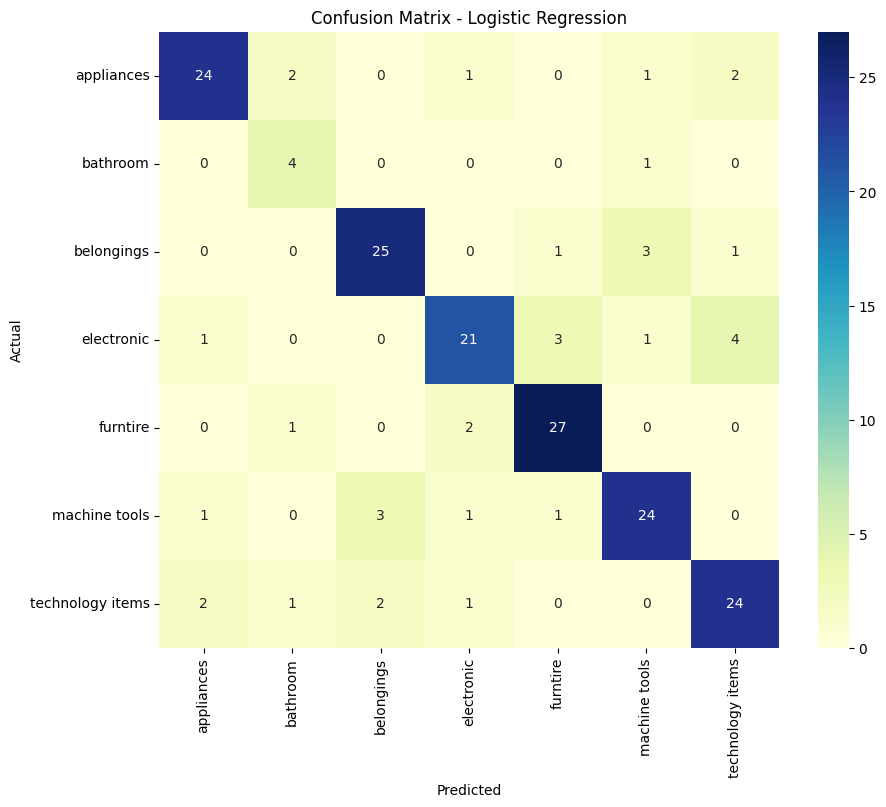

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='YlGnBu',
    xticklabels=[categories[i] for i in np.unique(y_test)],
    yticklabels=[categories[i] for i in np.unique(y_test)]
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


Phân tích độ tin cậy của mô hình (Prediction Confidence Analysis)

Đoạn mã dưới đây thực hiện các bước:

1. **Dự đoán xác suất** cho từng lớp bằng hàm `predict_proba()` trên tập kiểm thử.  
2. **Tính độ tự tin (confidence score)** — chính là giá trị xác suất cao nhất mà mô hình gán cho mỗi mẫu dự đoán.  
3. **Vẽ biểu đồ phân bố độ tin cậy** (confidence distribution) để quan sát mức độ chắc chắn của mô hình khi đưa ra dự đoán.  
4. **Tính giá trị trung bình** của độ tin cậy và **đưa ra nhận xét tổng quát**:
   - `> 0.8` → **Mô hình rất tự tin** trên hầu hết dự đoán.  
   - `0.6 – 0.8` → **Mức tự tin trung bình**, mô hình khá chắc chắn trong phần lớn trường hợp.  
   - `< 0.6` → **Mô hình chưa chắc chắn**, cần cải thiện thêm dữ liệu hoặc đặc trưng.


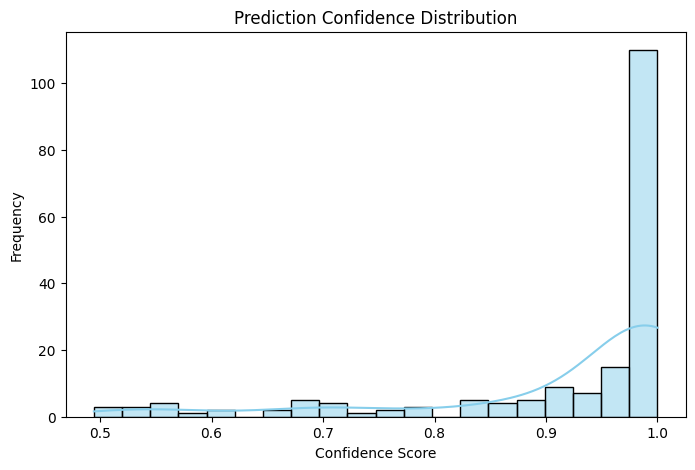

CONFIDEMCE SUMMARY
Average confidence: 91.94%
The model is highly confident on most predictions


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán xác suất
y_proba = clf.predict_proba(X_test_reduced)

# Tính độ tự tin
confidence_scores = np.max(y_proba, axis=1)

# Vẽ biểu đồ phân bố độ tin cậy
plt.figure(figsize=(8,5))
sns.histplot(confidence_scores, bins=20, kde=True, color='skyblue')
plt.title("Prediction Confidence Distribution")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.show()

# Thống kê
avg_conf = np.mean(confidence_scores)
print("CONFIDEMCE SUMMARY")
print(f"Average confidence: {avg_conf:.2%}")
if (avg_conf > 0.8):
  print("The model is highly confident on most predictions")
elif (avg_conf > 0.6):
  print("The model has moderate confidence, fairly sure in most cases")
else:
  print("The model is uncertain confidence is generally low")

Phân tích độ tin cậy dự đoán (Confidence Analysis)

Đoạn mã hiển thị **Top 5 mẫu tự tin nhất** và **Top 5 mẫu ít tự tin nhất** của mô hình.

- **Confidence**: xác suất cao nhất mà mô hình gán cho dự đoán.  
- **High-confidence samples** → mô hình rất chắc chắn, dễ phân loại.  
- **Low-confidence samples** → mô hình phân vân, có thể dự đoán sai.  

→ Giúp nhận biết khi nào mô hình đáng tin cậy và khi nào cần cải thiện.


In [ ]:
import pandas as pd

# Top 5 most confident predictions
top_conf_idx = np.argsort(confidence_scores)[-5:][::-1]
top_conf_df = pd.DataFrame({
    "Sample Index": top_conf_idx,
    "True Label": [y_test[i] for i in top_conf_idx],
    "Predicted Label": [y_pred[i] for i in top_conf_idx],
    "Confidence": [confidence_scores[i] for i in top_conf_idx]
})

# Top 5 least confident predictions
low_conf_idx = np.argsort(confidence_scores)[:5]
low_conf_df = pd.DataFrame({
    "Sample Index": low_conf_idx,
    "True Label": [y_test[i] for i in low_conf_idx],
    "Predicted Label": [y_pred[i] for i in low_conf_idx],
    "Confidence": [confidence_scores[i] for i in low_conf_idx]
})

# Hiển thị bảng gọn
print("TOP 5 MOST CONFIDENT PREDICTIONS")
display(top_conf_df.style.format({"Confidence": "{:.6f}"}))

print("\nTOP 5 LEAST CONFIDENT PREDICTIONS")
display(low_conf_df.style.format({"Confidence": "{:.6f}"}))

# Chú thích ngắn gọn
print("\nINTERPRETATION")
print("High-confidence samples: clear and easy to classify")
print("Low-confidence samples: uncertain or possibly misclassified")


TOP 5 MOST CONFIDENT PREDICTIONS


,Sample Index,True Label,Predicted Label,Confidence
0,126,5,5,1.000000
1,48,4,4,1.000000
2,82,4,4,0.999996
3,184,5,5,0.999989
4,133,4,4,0.999989



TOP 5 LEAST CONFIDENT PREDICTIONS


,Sample Index,True Label,Predicted Label,Confidence
0,14,3,6,0.494362
1,130,5,4,0.502218
2,74,5,2,0.503899
3,36,3,3,0.526878
4,45,1,5,0.528412



INTERPRETATION
High-confidence samples: clear and easy to classify
Low-confidence samples: uncertain or possibly misclassified


Báo cáo độ chính xác theo từng lớp (Per-Class Accuracy Report)

Đoạn mã này tính **độ chính xác riêng cho từng lớp** để xem mô hình hoạt động tốt ở lớp nào và kém ở lớp nào.

- **Accuracy (%)** = (Số mẫu dự đoán đúng / Tổng số mẫu của lớp) × 100  
- **Interpretation** mô tả mức độ nhận diện của mô hình:
  - 0% → hoàn toàn thất bại.  
  - 1–39% → độ chính xác thấp, mô hình hay nhầm lớp.  
  - 40–59% → trung bình, mô hình hiểu một phần đặc trưng lớp.  
  - 60–79% → tốt, nhận diện khá chính xác.  
  - 80–100% → xuất sắc, phân biệt lớp gần như hoàn hảo.  

→ Giúp xác định **lớp nào cần thêm dữ liệu hoặc tinh chỉnh mô hình**.


In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

# Đánh giá độ chính xác theo từng lớp
unique_labels = np.unique(y_test)
records = []

for label in unique_labels:
    mask = (y_test == label)
    total = np.sum(mask)
    correct = np.sum((y_pred == y_test) & mask)
    acc_value = accuracy_score(y_test[mask], y_pred[mask]) if total > 0 else 0

    #Giải thích kết quả theo độ chính xác
    if acc_value == 0:
        explanation = (
            "0% - The model failed to correctly classify any samples in this class. "
            "This indicates it has not learned the class characteristics at all."
        )
    elif acc_value < 0.4:
        explanation = (
            f"{acc_value*100:.2f}% - Low accuracy. The model often confuses this class with others. "
            "It has difficulty distinguishing this category."
        )
    elif acc_value < 0.6:
        explanation = (
            f"{acc_value*100:.2f}% - Moderate accuracy. The model recognizes some features "
            "of this class but still misclassifies a significant portion."
        )
    elif acc_value < 0.8:
        explanation = (
            f"{acc_value*100:.2f}% - Good accuracy. The model captures most of the class features "
            "but minor confusion remains."
        )
    else:
        explanation = (
            f"{acc_value*100:.2f}% - Excellent accuracy. The model almost perfectly distinguishes this class."
        )
    # Lưu kết quả
    records.append({
        "Class": categories[label],
        "Accuracy (%)": round(acc_value * 100, 2),
        "Correct/Total": f"{correct}/{total}",
        "Interpretation": explanation
    })
df_acc = pd.DataFrame(records)
print("\n" + "PER-CLASS ACCURACY REPORT".center(70))
display(df_acc)
print("\n" + "GENERAL INTERPRETATION OF ACCURACY".center(70))
print("0% - Model completely failed to recognize the class")
print("1%-39% - Low accuracy: model frequently misclassifies this class")
print("40%-59% - Moderate accuracy: model partially understands the class features")
print("60%-79% - Good accuracy: model recognizes most of the samples correctly")
print("80%-100% - Excellent accuracy: model has strong understanding of the class")
print("Note: Accuracy = (Number of correctly predicted samples / Total samples in the class) × 100\n")


                      PER-CLASS ACCURACY REPORT                       


,Class,Accuracy (%),Correct/Total,Interpretation
0,appliances,80.00,24/30,80.00% - Excellent accuracy. The model almost ...
1,bathroom,80.00,4/5,80.00% - Excellent accuracy. The model almost ...
2,belongings,83.33,25/30,83.33% - Excellent accuracy. The model almost ...
3,electronic,70.00,21/30,70.00% - Good accuracy. The model captures mos...
4,furntire,90.00,27/30,90.00% - Excellent accuracy. The model almost ...
5,machine tools,80.00,24/30,80.00% - Excellent accuracy. The model almost ...
6,technology items,80.00,24/30,80.00% - Excellent accuracy. The model almost ...



                  GENERAL INTERPRETATION OF ACCURACY                  
0% - Model completely failed to recognize the class
1%-39% - Low accuracy: model frequently misclassifies this class
40%-59% - Moderate accuracy: model partially understands the class features
60%-79% - Good accuracy: model recognizes most of the samples correctly
80%-100% - Excellent accuracy: model has strong understanding of the class
Note: Accuracy = (Number of correctly predicted samples / Total samples in the class) × 100



Biểu đồ độ chính xác theo từng lớp (Per-Class Accuracy Chart)

Đoạn mã vẽ **biểu đồ cột thể hiện độ chính xác (%) của từng lớp**, giúp đánh giá trực quan hiệu suất mô hình:

- **Trục X:** Tên hoặc nhãn lớp.  
- **Trục Y:** Độ chính xác dự đoán (%).  
- **Màu sắc:** Đại diện cho từng lớp khác nhau.  
- **Chú thích trên cột:** Hiển thị giá trị chính xác cụ thể.  

→ Biểu đồ giúp dễ dàng **phát hiện lớp nào mô hình học tốt và lớp nào còn yếu**, hỗ trợ định hướng cải thiện dữ liệu hoặc mô hình.


DISPLAYING PER-CLASS ACCURACY CHART


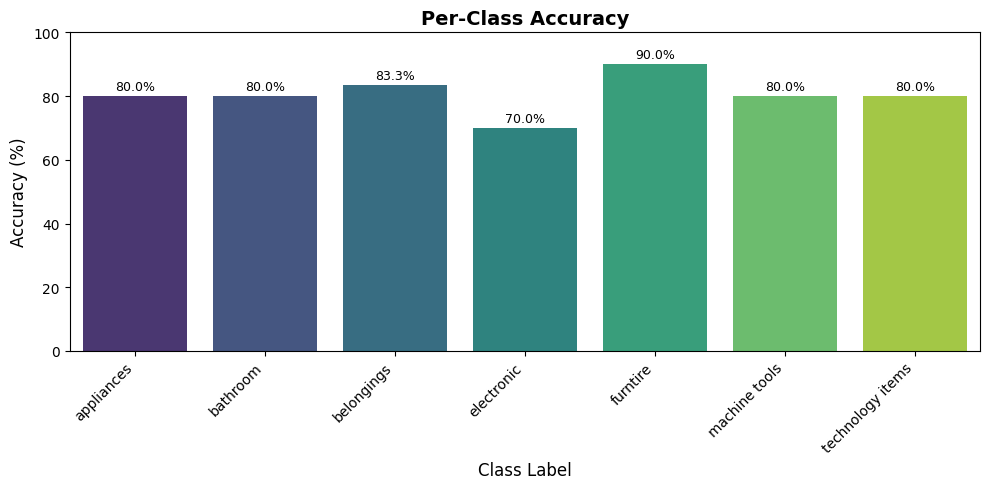

In [ ]:
# --- Biểu đồ trực quan theo từng lớp ---
import matplotlib.pyplot as plt
import seaborn as sns

print("DISPLAYING PER-CLASS ACCURACY CHART")
plt.figure(figsize=(10, 5))
# Vẽ biểu đồ
sns.barplot(
    data=df_acc,
    x="Class",
    y="Accuracy (%)",
    hue="Class",
    dodge=False,
    palette="viridis",
    legend=False
)
plt.title("Per-Class Accuracy", fontsize=14, fontweight="bold")
plt.xlabel("Class Label", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(0, 100)
plt.xticks(rotation=45, ha='right')
# Hiển thị phần trăm cho các cột
for index, value in enumerate(df_acc["Accuracy (%)"]):
    plt.text(index, value + 1, f"{value:.1f}%", ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()


Đánh giá mô hình bằng Cross-Validation

Đoạn mã sử dụng **Stratified K-Fold (k=3)** để đánh giá độ ổn định và khả năng tổng quát của mô hình Logistic Regression.

- **Mỗi fold**: mô hình được huấn luyện và kiểm thử trên tập dữ liệu khác nhau.  
- **Mean Accuracy**: trung bình độ chính xác qua các fold.  
- **Standard Deviation**: độ dao động giữa các lần kiểm thử (độ ổn định).  

 **Giải thích nhanh:**
- Độ lệch chuẩn < 0.05 → mô hình **ổn định và nhất quán**.  
- Độ lệch chuẩn ≥ 0.05 → mô hình **chưa ổn định**, cần kiểm tra lại dữ liệu hoặc tham số.


In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# Khởi tạo logistic regresson
clf = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced'
)
# Thực hiện cross-validation
cv_scores = cross_val_score(
    clf,
    X_train_reduced,
    y_train,
    cv=cv,
    scoring='accuracy'
)

print("\nCross-Validation Results")
for i, score in enumerate(cv_scores, start=1):
    print(f"Fold {i}: {score:.2%}")

print(f"\nMean Accuracy : {np.mean(cv_scores):.2%}")
print(f"Standard Deviation: {np.std(cv_scores):.2%}")
# Kiểm tra độ ổn định của mô hình
if np.std(cv_scores) < 0.05:
    print("\nModel performance is stable across folds.")
else:
    print("\nModel shows some variability across folds.")


Cross-Validation Results
Fold 1: 83.33%
Fold 2: 70.83%
Fold 3: 74.13%

Mean Accuracy : 76.10%
Standard Deviation: 5.29%

Model shows some variability across folds.
